In [52]:
# Torch-related imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset

# Scikit-learn-related imports
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score

# Nibabel and Scipy imports (for handling fMRI and image processing)
import nibabel as nib
import scipy.ndimage as ndimage  # For smoothing

# NumPy, Matplotlib, and Seaborn (for data manipulation and visualization)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# OS for file system operations
import os

In [53]:
import torch
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [54]:
# from google.colab import drive
# drive.mount('/content/drive')

# root_dir = os.path.join('/content/drive', 'My Drive', 'UCR', '2-2024', 'InvCC', 'ADHD200', 'Datasets', 'preprocessed')

import os
from sklearn.utils.class_weight import compute_class_weight

root_dir = os.path.join('data', 'preprocessed')

tdc_dir = os.path.join(root_dir, 'TDC')
adhd_dir = os.path.join(root_dir, 'ADHD')

# To save autoencoder state dict
save_path = os.path.join(root_dir, 'autoencoder.pt')

# Recursively find all .nii.gz files in TDC and ADHD folders
tdc_file_paths = [
    os.path.join(root, file)
    for root, _, files in os.walk(tdc_dir)
    for file in files if file.endswith('.nii.gz')
]

adhd_file_paths = [
    os.path.join(root, file)
    for root, _, files in os.walk(adhd_dir)
    for file in files if file.endswith('.nii.gz')
]

# Adding labels
tdc_labels = [0] * len(tdc_file_paths)
adhd_labels = [1] * len(adhd_file_paths)

file_paths = tdc_file_paths + adhd_file_paths
labels = tdc_labels + adhd_labels

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f'Class weights: ', class_weights)

Class weights:  tensor([0.8004, 1.3323], device='cuda:0')


# Preprocessing

In [55]:
import torch
import nibabel as nib
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from scipy import ndimage

class FMRI_Dataset(Dataset):
    def __init__(self, file_paths, labels, max_shape, smoothing_sigma=1, augment=False):
        self.file_paths = file_paths  # List of paths to the fMRI data files
        self.labels = labels  # Corresponding labels
        self.max_shape = max_shape  # Shape to pad all inputs to (e.g., [1, 61, 73, 61])
        self.smoothing_sigma = smoothing_sigma  # Standard deviation for Gaussian smoothing
        self.augment = augment  # Apply augmentations if True

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load fMRI data
        fmri_img = nib.load(self.file_paths[idx])
        data = fmri_img.get_fdata()

        # Apply Gaussian smoothing
        data = self.smooth_data(data)

        # Apply augmentations if enabled
        if self.augment:
            data = self.apply_augmentations(data)

        # Normalize the data
        data = self.normalize_data(data)

        # Convert to tensor and add missing dimensions
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

        # Pad the tensor to the specified max_shape
        data_padded = F.pad(data_tensor, pad=self.calculate_padding(data_tensor.shape), mode='constant', value=0)

        # Ensure the final shape matches max_shape
        data_padded = data_padded.view(*self.max_shape)

        # Get the label
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return data_padded, label

    def apply_augmentations(self, data):
        data = self.add_noise(data)
        data = self.random_rotate(data)
        data = self.random_intensity_shift(data)
        return data

    def add_noise(self, data, mean=0, std=0.01):
        noise = np.random.normal(mean, std, data.shape)
        return data + noise

    def random_rotate(self, data):
        angles = np.random.uniform(-5, 5, size=3)
        return ndimage.rotate(data, angle=angles[0], axes=(1, 2), reshape=False, mode='nearest')

    def random_intensity_shift(self, data, shift_limit=0.05):
        shift_value = np.random.uniform(-shift_limit, shift_limit)
        return data + shift_value

    def calculate_padding(self, current_shape):
        padding = []
        for current_dim, max_dim in zip(reversed(current_shape), reversed(self.max_shape)):
            pad_total = max_dim - current_dim
            padding.append(pad_total // 2)
            padding.append(pad_total - (pad_total // 2))
        return padding

    def normalize_data(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std if std > 0 else data

    def smooth_data(self, data):
        return ndimage.gaussian_filter(data, sigma=self.smoothing_sigma)

In [56]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming you already have file_paths and labels defined as in your previous code

# Parameters
batch_size = 4
max_shape = [1, 61, 73, 61]

# Stratified Shuffle Split
labels = np.array(labels)
dataset = FMRI_Dataset(file_paths, labels, max_shape)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)  # 70% train, 30% test

for train_index, test_index in sss.split(file_paths, labels):
    train_file_paths, test_file_paths = np.array(file_paths)[train_index], np.array(file_paths)[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

# Further split the test set into validation and test sets
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # 50% of the test set for validation
for val_index, test_index in sss_val.split(test_file_paths, test_labels):
    val_file_paths, final_test_file_paths = np.array(test_file_paths)[val_index], np.array(test_file_paths)[test_index]
    val_labels, final_test_labels = test_labels[val_index], test_labels[test_index]

# Print the results
print(f"Training set size: {len(train_file_paths)}")
print(f"Validation set size: {len(val_file_paths)}")
print(f"Test set size: {len(final_test_file_paths)}")

# Create datasets
train_dataset = FMRI_Dataset(train_file_paths.tolist(), train_labels.tolist(), max_shape)
val_dataset = FMRI_Dataset(val_file_paths.tolist(), val_labels.tolist(), max_shape)
test_dataset = FMRI_Dataset(final_test_file_paths.tolist(), final_test_labels.tolist(), max_shape)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training set size: 3570
Validation set size: 765
Test set size: 765


# CNN-AE

In [10]:
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(16, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=3, stride=2, padding=(1, 1, 1), output_padding=(0, 1, 0)),
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=(1, 1, 1), output_padding=(1, 0, 1)),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 16, kernel_size=3, stride=2, padding=(1, 0, 0), output_padding=(0, 0, 1)),
            nn.ReLU(),
            nn.ConvTranspose3d(16, 1, kernel_size=3, stride=2, padding=(1, 0, 0), output_padding=(0, 1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = CNN_Autoencoder().to(device)

# Generate random input matching new shape [1, 1, 53, 64] (Batch size 1)
inputs = torch.rand((1, 53, 64, 46)).to(device)  # Example input
output = autoencoder(inputs)
print(output.shape)  # should match the input shape [1, 53, 64, 46]

# Loss and optimizer
criterion = nn.MSELoss()  # Since it's an autoencoder, Mean Squared Error is commonly used
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-5)

torch.Size([1, 53, 64, 46])


# CNN

### Using pretrained weights

In [11]:
# Model definition

class CNNOnEncoder(nn.Module):
    def __init__(self, autoencoder, num_classes):
        super(CNNOnEncoder, self).__init__()
        self.encoder = autoencoder.encoder  # Use the encoder from the autoencoder
        self.conv1 = nn.Conv3d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveMaxPool3d(output_size=(8, 8, 5))
        self.fc1 = nn.Linear(128 * 8 * 8 * 5, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # print(x.shape)
        x = self.encoder(x)
        # print(f'Encoder {x.shape}')
        x = self.pool(F.relu(self.conv1(x)))  # First conv + pooling
        # print(f'First conv + pooling {x.shape}')
        x = self.pool(F.relu(self.conv2(x)))  # Second conv + pooling
        # print(f'Second conv + pooling {x.shape}')
        x = self.pool(F.relu(self.conv3(x)))  # Second conv + pooling
        x = x.unsqueeze(0)
        x = x.view(x.size(1), -1)  # Flatten
        # print(f'Flattened {x.shape}')
        x = F.relu(self.fc1(x))  # First fully connected layer
        x = self.fc2(x)  # Output layer
        x = F.softmax(x, dim=1)  # Apply softmax for probabilistic output
        return x

In [14]:
# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder()
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.to(device)
trained_autoencoder.eval() # Set the model to evaluation mode

# Create an instance of the new model
cnn_with_ae_model = CNNOnEncoder(trained_autoencoder, num_classes=2).to(device)

# Optionally, freeze the encoder layers, Frozen= false, Unfrozen= true
for param in cnn_with_ae_model.encoder.parameters():
    param.requires_grad = True

class_weights = torch.tensor([1.0, 1.1])
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(cnn_with_ae_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    cnn_with_ae_model.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs_reduced = torch.mean(inputs, dim=-1)
        inputs = inputs_reduced

        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = cnn_with_ae_model(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(trainloader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    cnn_with_ae_model.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in valloader:
            val_inputs_reduced = torch.mean(val_inputs, dim=-1)
            val_inputs = val_inputs_reduced.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = cnn_with_ae_model(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(valloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(cnn_with_ae_model.state_dict(), 'best_cnn_with_ae.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(cnn_with_ae_model.state_dict(), f'cnn_with_ae_epoch{epoch}.pt')

# Save the final trained model
torch.save(cnn_with_ae_model.state_dict(), 'cnn_with_ae_final.pt')

KeyboardInterrupt: 

Accuracy of the CNN with autoencoder on the test images: 52.23%
Average loss on the test images: 0.6923


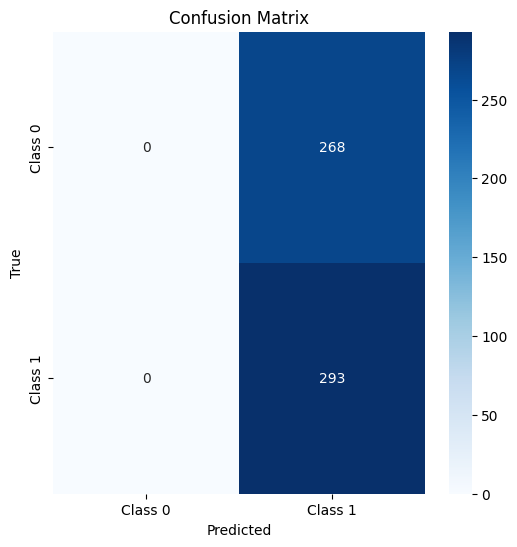

In [118]:
# Testing loop

# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder()
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.to(device)
trained_autoencoder.eval() # Set the model to evaluation mode

# Load the model
num_classes = 2

classifier_model = CNNOnEncoder(trained_autoencoder, num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('cnn_with_ae_epoch7.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs_reduced = torch.mean(inputs, dim=-1)
        inputs = inputs_reduced

        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = classifier_model(inputs)
        # print(outputs.shape)

        loss = criterion(output, labels)

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(testloader)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

# Print accuracy and average loss
print(f'Accuracy of the CNN with autoencoder on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')


### Not using pretrained weights

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(128)
        self.conv3 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(256)
        self.pool = nn.AdaptiveMaxPool3d(output_size=(8, 8, 5))
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(256 * 8 * 8 * 5, 256)
        self.fc2 = nn.Linear(256, num_classes)

        # Initialize weights
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, (nn.Conv3d, nn.Linear)):
            nn.init.kaiming_uniform_(m.weight, a=nn.init.calculate_gain('relu'))  # Use He initialization
            if m.bias is not None:
                nn.init.zeros_(m.bias)  # Initialize biases to zero

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [58]:
simple_cnn_model = SimpleCNN(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(simple_cnn_model.parameters(), lr=0.01)

example_input = torch.randn(4, 1, 61, 73, 61)
example_output = simple_cnn_model(example_input.to(device))
print("Output shape:", example_output.shape)

Output shape: torch.Size([4, 2])


In [59]:
# Training loop

num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    simple_cnn_model.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = simple_cnn_model(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    simple_cnn_model.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = simple_cnn_model(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)


    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(simple_cnn_model.state_dict(), 'best_simple_cnn.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(simple_cnn_model.state_dict(), f'simple_cnn_epoch{epoch+1}.pt')

# Save the final trained model
torch.save(simple_cnn_model.state_dict(), 'simple_cnn_final.pt')

Epoch [1/100], Train Loss: 5.2868, Train Accuracy: 0.6487
Epoch [1/100], Val Loss: 0.6721, Val Accuracy: 0.6601
Model saved at epoch 1 with validation loss: 0.6721
Epoch [2/100], Train Loss: 0.7491, Train Accuracy: 0.6555
Epoch [2/100], Val Loss: 0.6604, Val Accuracy: 0.6627
Model saved at epoch 2 with validation loss: 0.6604
Epoch [3/100], Train Loss: 1.1049, Train Accuracy: 0.6468
Epoch [3/100], Val Loss: 0.6661, Val Accuracy: 0.6601
Epoch [4/100], Train Loss: 0.6797, Train Accuracy: 0.6496
Epoch [4/100], Val Loss: 0.6677, Val Accuracy: 0.6601
Epoch [5/100], Train Loss: 0.6849, Train Accuracy: 0.6521
Epoch [5/100], Val Loss: 0.6779, Val Accuracy: 0.6627
Epoch [6/100], Train Loss: 0.6880, Train Accuracy: 0.6347
Epoch [6/100], Val Loss: 0.6912, Val Accuracy: 0.6248
Epoch [7/100], Train Loss: 0.6929, Train Accuracy: 0.5866
Epoch [7/100], Val Loss: 0.6919, Val Accuracy: 0.6248
Epoch [8/100], Train Loss: 0.6925, Train Accuracy: 0.6246
Epoch [8/100], Val Loss: 0.6912, Val Accuracy: 0.6248


KeyboardInterrupt: 

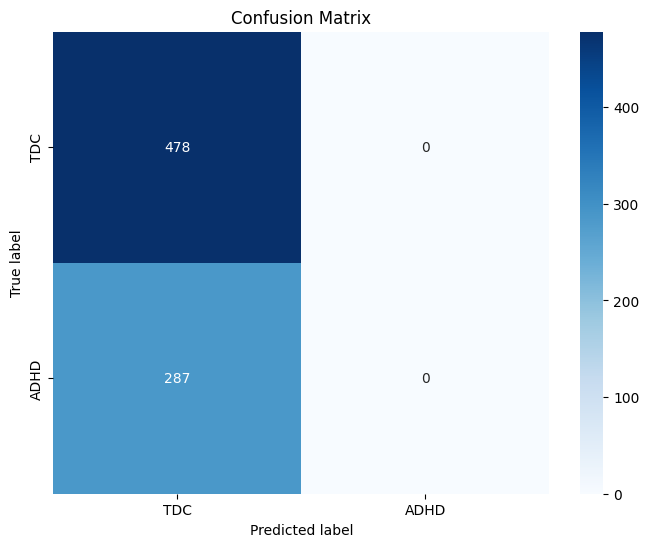

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['TDC', 'ADHD'], yticklabels=['TDC', 'ADHD'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Accuracy of the simple CNN on the test images: 52.23%
Average loss on the test images: 0.6925


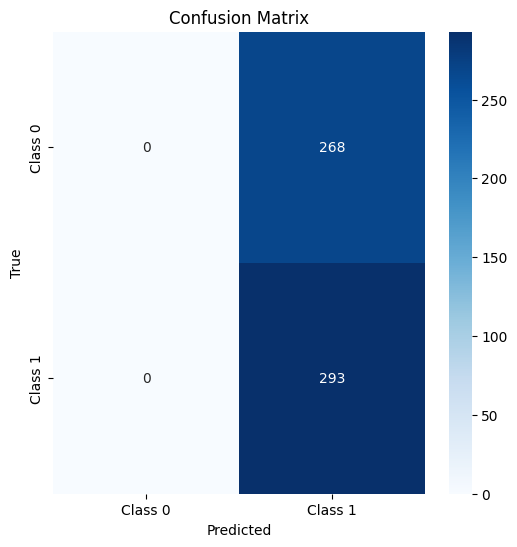

In [122]:
# Testing loop

# Load the model
classifier_model = SimpleCNN(num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('simple_cnn_epoch1.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs_reduced = torch.mean(inputs, dim=-1)
        inputs = inputs_reduced

        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = simple_cnn_model(inputs)
        # print(outputs.shape)

        loss = criterion(output, labels)

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(testloader)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

# Print accuracy and average loss
print(f'Accuracy of the simple CNN on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')


# CNN-LSTM

### Using pretrained weights

In [31]:
class CNNLSTMOnAutoencoder(nn.Module):
    def __init__(self, autoencoder, hidden_size, num_classes):
        super(CNNLSTMOnAutoencoder, self).__init__()
        self.encoder = autoencoder.encoder
        self.conv1 = nn.Conv3d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveMaxPool3d(output_size=(8, 8, 5))
        self.lstm = None
        self.fc = None

    def forward(self, x):
        batch_size = x.size(0)

        x = self.encoder(x)
        # Apply convolutions, dropout, and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        # print(f'First conv + pooling {x.shape}')
        x = self.pool(F.relu(self.conv2(x)))
        # print(f'Second conv + pooling {x.shape}')
        x = self.pool(F.relu(self.conv3(x)))
        # print(f'Third conv + pooling {x.shape}')

        # Get the final shape after convolutions
        conv_output_shape = x.shape
        # print(f"Convolution output shape: {conv_output_shape}")
        
        # Extract available dimensions for reshaping
        channels, new_height, new_width, new_depth = conv_output_shape

        # Calculate the LSTM input size
        lstm_input_size = channels * new_height * new_width

        # Reshape for LSTM input
        x = x.view(batch_size, new_depth, lstm_input_size)

        # Initialize LSTM and FC layers if not yet initialized
        if self.lstm is None:
            self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=128, batch_first=True).to(x.device)
            self.fc = nn.Linear(in_features=128, out_features=2).to(x.device)

        # Pass through LSTM and FC
        lstm_out, _ = self.lstm(x)
        out = F.relu(self.fc(lstm_out[:, -1, :]))
        out = F.softmax(out, dim=1)  # Apply softmax for probabilistic output
        return out

In [32]:
# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder().to(device)
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.eval() # Set the model to evaluation mode

# Model with pretrained weights
cnn_lstm_with_ae = CNNLSTMOnAutoencoder(trained_autoencoder, 128, 2).to(device)

# Optionally, freeze the encoder layers, Frozen= false, Unfrozen= true
for param in cnn_lstm_with_ae.encoder.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_lstm_with_ae.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Training loop

num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    cnn_lstm_with_ae.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs_reduced = torch.mean(inputs, dim=-1)
        inputs = inputs_reduced

        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = cnn_lstm_with_ae(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(trainloader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    cnn_lstm_with_ae.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in valloader:
            val_inputs_reduced = torch.mean(val_inputs, dim=-1)
            val_inputs = val_inputs_reduced.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = cnn_lstm_with_ae(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(valloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(cnn_lstm_with_ae.state_dict(), 'best_cnnlstm_with_ae.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(cnn_lstm_with_ae.state_dict(), f'cnnlstm_with_ae_epoch{epoch}.pt')

# Save the final trained model
torch.save(cnn_lstm_with_ae.state_dict(), 'cnnlstm_with_ae_final.pt')


In [ ]:
# Testing loop

# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder().to(device)
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.eval() # Set the model to evaluation mode

# Load the model
classifier_model = CNNLSTMOnAutoencoder(trained_autoencoder, hidden_size=128, num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('cnnlstm_with_ae_final.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs_reduced = torch.mean(inputs, dim=-1)
        inputs = inputs_reduced

        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = simple_cnn_model(inputs)
        # print(outputs.shape)

        loss = criterion(output, labels)

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(testloader)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

# Print accuracy and average loss
print(f'Accuracy of the CNN-LSTM with autoencoder on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')

### Not using pretrained weights

In [14]:
class SimpleCNNLSTM(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(SimpleCNNLSTM, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveMaxPool3d(output_size=(8, 8, 5))
        self.lstm = None # To be defined later after determining input size
        self.fc = None  # To be defined later after determining LSTM output size

    def forward(self, x):
        batch_size = x.size(0)

        # Apply convolutions, dropout, and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        # print(f'First conv + pooling {x.shape}')
        x = self.pool(F.relu(self.conv2(x)))
        # print(f'Second conv + pooling {x.shape}')
        x = self.pool(F.relu(self.conv3(x)))
        # print(f'Third conv + pooling {x.shape}')

        # Get the final shape after convolutions
        conv_output_shape = x.shape
        # print(f"Convolution output shape: {conv_output_shape}")
        
        # Extract available dimensions for reshaping
        channels, new_height, new_width, new_depth = conv_output_shape

        # Calculate the LSTM input size
        lstm_input_size = channels * new_height * new_width

        # Reshape for LSTM input
        x = x.view(batch_size, new_depth, lstm_input_size)

        # Initialize LSTM and FC layers if not yet initialized
        if self.lstm is None:
            self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=128, batch_first=True).to(x.device)
            self.fc = nn.Linear(in_features=128, out_features=2).to(x.device)

        # Pass through LSTM and FC
        lstm_out, _ = self.lstm(x)
        out = F.relu(self.fc(lstm_out[:, -1, :]))
        out = F.softmax(out, dim=1)  # Apply softmax for probabilistic output
        return out

In [15]:
# Model without pretrained weights
simple_cnnlstm = SimpleCNNLSTM(hidden_size=128, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(simple_cnnlstm.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Training loop

num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    simple_cnnlstm.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs_reduced = torch.mean(inputs, dim=-1)
        inputs = inputs_reduced

        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = simple_cnnlstm(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(trainloader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    simple_cnnlstm.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in valloader:
            val_inputs_reduced = torch.mean(val_inputs, dim=-1)
            val_inputs = val_inputs_reduced.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = simple_cnnlstm(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(valloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(simple_cnnlstm.state_dict(), 'best_simple_cnnlstm.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(simple_cnnlstm.state_dict(), f'simple_cnnlstm_epoch{epoch}.pt')

# Save the final trained model
torch.save(simple_cnnlstm.state_dict(), 'simple_cnnlstm_final.pt')

In [ ]:
# Testing loop

# Load the model
classifier_model = SimpleCNNLSTM(hidden_size=128, num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('simple_cnnlstm_final.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs_reduced = torch.mean(inputs, dim=-1)
        inputs = inputs_reduced

        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = simple_cnn_model(inputs)
        # print(outputs.shape)

        loss = criterion(output, labels)

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(testloader)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

# Print accuracy and average loss
print(f'Accuracy of the simple CNN-LSTM on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')